In [ ]:
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
import torch
import pandas as pd
import os
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from tqdm import tqdm  # Import tqdm for progress bar
import seaborn as sns
import random

In [3]:
def set_seed(seed=42):
    torch.manual_seed(seed)             # CPU随机性
    torch.cuda.manual_seed(seed)        # GPU随机性（单卡）
    torch.cuda.manual_seed_all(seed)    # GPU随机性（多卡）
    np.random.seed(seed)                # NumPy随机性
    random.seed(seed)                   # Python随机性
    torch.backends.cudnn.deterministic = True  # 固定卷积算法
    torch.backends.cudnn.benchmark = False     # 禁止自动寻找最优算法（为了可重复性）

In [4]:
set_seed(41)
folderpath_first = '/home/yuqster/files/research/dataset/Oil_mix19'
folderpath_second = '/home/yuqster/files/research/dataset/Oil_mix20'
folderpath_third = '/home/yuqster/files/research/dataset/Oil_mix21'
data_list_first = []
labels_first = []
data_list_second = []
labels_second = []
data_list_third = []
labels_third = []
material = ['oil','vinegar','water']

In [5]:

file_name = []
for i in range(len(material)):
    file_name.append([f for f in os.listdir(folderpath_first) if material[i] in f])
    for path in file_name[i]:
        data = pd.read_csv(f'{folderpath_first}/{path}')
        trans = data.values
        data_list_first.append(trans)
        labels_first.append(i)

In [6]:
file_name = []
for i in range(len(material)):
    file_name.append([f for f in os.listdir(folderpath_second) if material[i] in f])
    for path in file_name[i]:
        data = pd.read_csv(f'{folderpath_second}/{path}')
        trans = data.values
        data_list_second.append(trans)
        labels_second.append(i)

In [7]:
file_name = []
for i in range(len(material)):
    file_name.append([f for f in os.listdir(folderpath_third) if material[i] in f])
    for path in file_name[i]:
        data = pd.read_csv(f'{folderpath_third}/{path}')
        trans = data.values
        data_list_third.append(trans)
        labels_third.append(i)

In [8]:

data_list = data_list_third
labels = labels_third

X = np.array(data_list).squeeze()
y = np.array(labels).reshape(-1, 1)
print(X.shape)
print(y.shape)

(7302, 4096)
(7302, 1)


In [9]:
X_realtest = np.array(data_list_second).squeeze()
y_realtest = np.array(labels_second).reshape(-1,1)
print(f'X_second shape{X_realtest.shape},y_second shape{y_realtest.shape}')

X_second shape(3909, 4096),y_second shape(3909, 1)


In [10]:
device = torch.device(
    "cuda" if torch.cuda.is_available() 
    else "mps" if (hasattr(torch.backends, "mps") and torch.backends.mps.is_available()) 
    else "cpu"
)
print("Using device:", device)

Using device: cuda


In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=44)

scaler = RobustScaler(
    with_centering=True,    # 是否减去中位数，默认为 True
    with_scaling=True,      # 是否除以 IQR（默认 True）
    quantile_range=(25.0, 75.0)  # 用于计算 IQR 的上下分位数，默认为 (25, 75)
)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_realtest = scaler.fit_transform(X_realtest)

scaler = MinMaxScaler(feature_range=(0, len(material)-1))
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)
y_realtest = scaler.transform(y_realtest)


print(y_train)
print(y_realtest)
print(X_train.shape)
print(y_train.shape)
print(X_realtest.shape)
print(y_realtest.shape)

[[0.]
 [0.]
 [0.]
 ...
 [1.]
 [1.]
 [2.]]
[[0.]
 [0.]
 [0.]
 ...
 [2.]
 [2.]
 [2.]]
(5111, 4096)
(5111, 1)
(3909, 4096)
(3909, 1)


In [ ]:
class ANN_Model(nn.Module):

    def __init__(self):
        super(ANN_Model, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 8)
        self.fc4 = nn.Linear(8, 3)




    def forward(self, i):
        h1 = torch.relu(self.fc1(i))
        h2 = torch.relu(self.fc2(h1))
        h3 = torch.relu(self.fc3(h2))
        o4 = self.fc4(h3)
        return o4


In [13]:
model = ANN_Model().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001)

# 4. 将 numpy 数据转为 torch 张量并移动到 device
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

X_realtest_tensor = torch.tensor(X_realtest, dtype=torch.float32).to(device)
y_fourth_tensor = torch.tensor(y_realtest, dtype=torch.float32).to(device)

In [14]:
# 5. 训练模型
num_epochs = 10000
train_losses = []

# Convert y_train_tensor to the correct type
y_train_tensor = y_train_tensor.squeeze().long() # Remove extra dimension and convert to long

pbar = tqdm(range(num_epochs), desc="Training", leave=True)
for epoch in pbar:
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    
    # 更新进度条，显示当前 loss
    pbar.set_postfix(loss=loss.item())

Training:   0%|          | 0/10000 [00:00<?, ?it/s]

Training: 100%|██████████| 10000/10000 [00:18<00:00, 533.41it/s, loss=0.00243]


In [15]:
# Evaluate the model
model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    train_outputs = model(X_train_tensor)
    _, predicted = torch.max(test_outputs, 1)
    _, predicted_train = torch.max(train_outputs, 1)
    predicted_np = predicted.cpu().numpy()
    predicted_np_train = predicted_train.cpu().numpy()
    accuracy_train = accuracy_score(y_train,predicted_np_train)
    accuracy = accuracy_score(y_test, predicted_np)
    cm = confusion_matrix(y_test, predicted_np)

Accuracy: 0.9995435874030123
Accuracy_train: 1.0
Confusion Matrix:
[[726   0   0]
 [  0 741   0]
 [  1   0 723]]


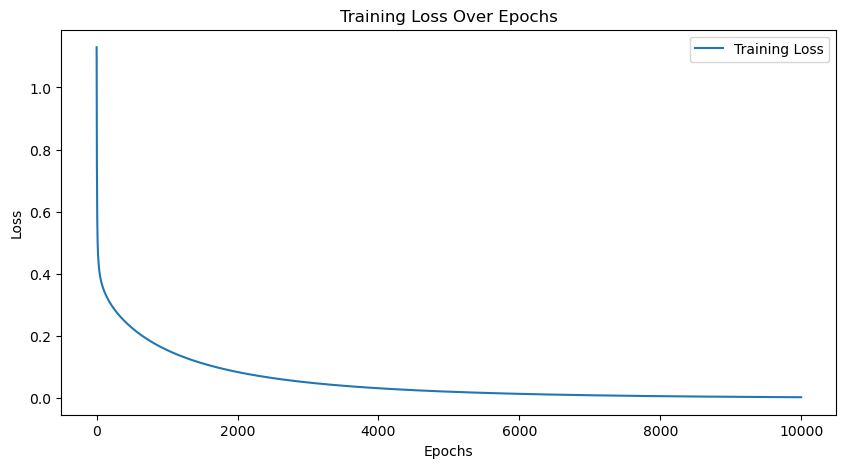

In [16]:
print(f'Accuracy: {accuracy}')
print(f'Accuracy_train: {accuracy_train}')
print(f'Confusion Matrix:\n{cm}')

# 7. 可视化训练损失
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.show()

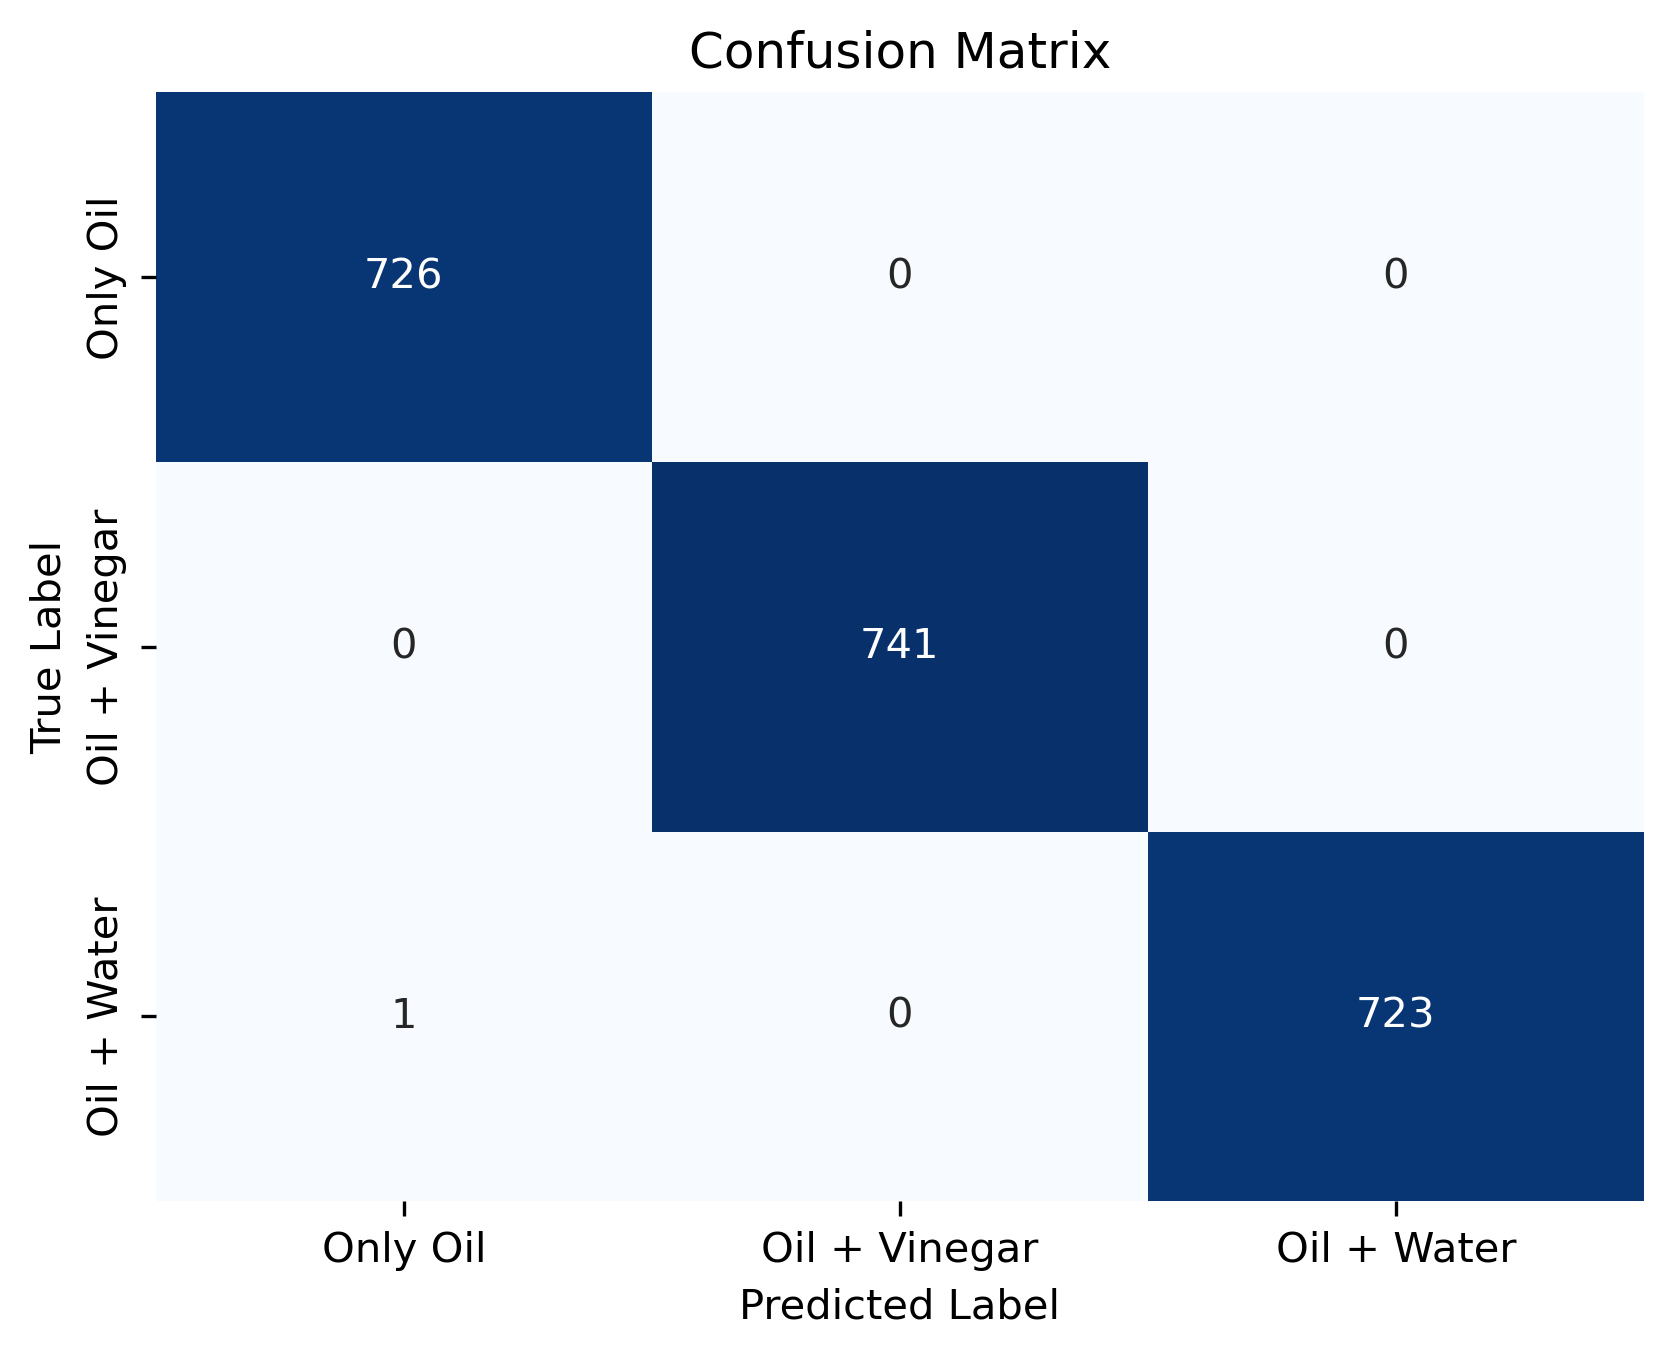

Accuracy: 0.9995435874030123
              precision    recall  f1-score   support

         oil       1.00      1.00      1.00       726
     vinegar       1.00      1.00      1.00       741
       water       1.00      1.00      1.00       724

    accuracy                           1.00      2191
   macro avg       1.00      1.00      1.00      2191
weighted avg       1.00      1.00      1.00      2191



In [26]:
# Plot Confusion Matrix
name = ['Only Oil', 'Oil + Vinegar', 'Oil + Water']
plt.figure(dpi=300)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=name,
            yticklabels=name,
            cbar=False)  # 关闭 color bar
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

# Save as PDF before show()
plt.savefig("/home/yuqster/files/research/figures/confusion.pdf", bbox_inches='tight')
plt.show()


# Convert y_test to integer labels
y_test_int = y_test.astype(int)

# Show classification reportaccuracy
report = classification_report(y_test_int, predicted_np,
                               target_names=material, labels=range(len(material)))
print("Accuracy:", accuracy)
print(report)

In [18]:
# Evaluate the model
model.eval()
with torch.no_grad():
    test_realtest_outputs = model(X_realtest_tensor)
    _, predicted_realtest = torch.max(test_realtest_outputs, 1)
    predicted_np_realtest = predicted_realtest.cpu().numpy()
    accuracy_realtest = accuracy_score(y_realtest, predicted_np_realtest)
    cm_realtest = confusion_matrix(y_realtest, predicted_np_realtest)

In [19]:
print(f'Accuracy: {accuracy_realtest}')
print(f'Confusion Matrix:\n{cm_realtest}')

Accuracy: 0.8598106932719366
Confusion Matrix:
[[1133    6  163]
 [  17 1229   56]
 [ 129  177  999]]


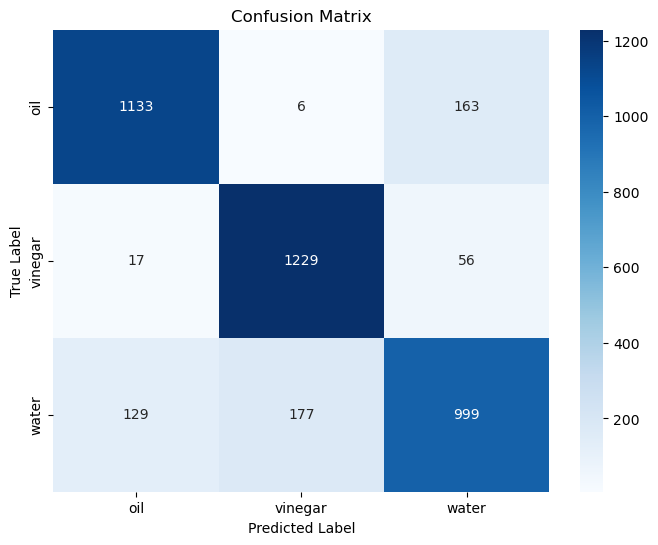

Accuracy: 0.8598106932719366
              precision    recall  f1-score   support

         oil       0.89      0.87      0.88      1302
     vinegar       0.87      0.94      0.91      1302
       water       0.82      0.77      0.79      1305

    accuracy                           0.86      3909
   macro avg       0.86      0.86      0.86      3909
weighted avg       0.86      0.86      0.86      3909



In [20]:
# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_realtest, annot=True, fmt="d", cmap="Blues",
            xticklabels=material,
            yticklabels=material)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix")
plt.show()

# Convert y_test to integer labels
y_test_int = y_realtest.astype(int)

# Show classification reportaccuracy
report = classification_report(y_test_int, predicted_np_realtest,
                               target_names=material, labels=range(len(material)))
print("Accuracy:", accuracy_realtest)
print(report)

In [21]:
activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach().cpu().numpy()
    return hook

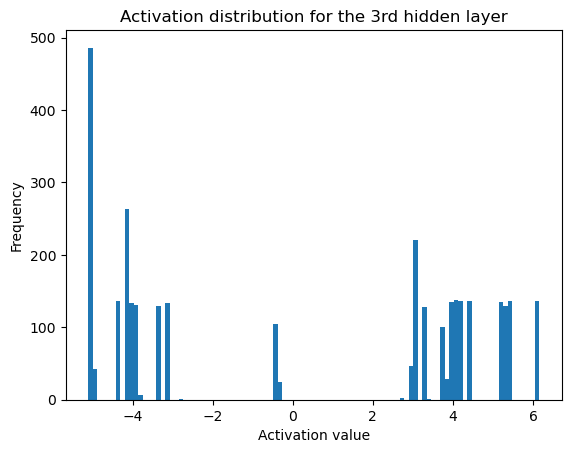

In [22]:
model.fc3.register_forward_hook(get_activation('fc3'))
# 前向传播一批数据
_ = model(torch.tensor(X_train[:400], dtype=torch.float32).to(device))

# 绘制 fc1 层的激活值直方图
plt.hist(activations['fc3'].flatten(), bins=100)
plt.title("Activation distribution for the 3rd hidden layer")
plt.xlabel("Activation value")
plt.ylabel("Frequency")
plt.show()